In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cubic_subproblem_solver import *

# Helper functions

In [10]:
def sigmoid(t: np.array):
    # if t.dtype is integer, computation will fail
    assert t.dtype == np.float64 or t.dtype == np.float32
    mask = t >= 0
    t[mask] = 1 / (1 + np.exp(-t[mask]))
    t[~mask] = 1 - 1 / (1 + np.exp(t[~mask]))
    return t


def train_Cubic_Newton(X, y, w0, n_iters, M_0):
    losses = []
    grads_norm = []
    M = M_0
    w = w0
    losses.append(loss(X,y,w))
    grads_norm.append(np.linalg.norm(gradient(X,y,w),2))
    for i in range(n_iters):
        loss_ = loss(X,y,w)
        grad = gradient(X,y,w)
        hess = hessian(X, y, w)
        h = cubic_subproblem_solver(grad, hess, M)
        w_next = w + h
        while (loss(X,y,w_next) > quadratic_form(loss_,grad,hess,M,w,w_next)):
            M *= 2
            h = cubic_subproblem_solver(grad, hess, M)
            w_next = w + h
        w = w_next
        losses.append(loss(X,y,w))
        grads_norm.append(np.linalg.norm(gradient(X,y,w),2))
        M /= 2
        print(f'iter {i+1: 3,d}: loss = {loss(X,y,w): .16f}, M = {M}')
    return w, losses, grads_norm


def train_GD(X, y, w0, n_iters, lr, print_every=10):
    losses = []
    grads_norm = []
    w = w0
    losses.append(loss(X,y,w))
    grads_norm.append(np.linalg.norm(gradient(X,y,w),2))
    for i in range(n_iters):
        grad = gradient(X,y,w)
        w = w - lr * grad
        losses.append(loss(X,y,w))
        grads_norm.append(np.linalg.norm(gradient(X,y,w),2))
        if (i+1) % print_every == 0:
            print(f'iter {i+1: 4,d}: loss = {loss(X,y,w): .16f}')
    return w, losses, grads_norm

# Regression with cubic loss

$\mathcal{L}(w) = \frac{1}{N} \sum_{i=1}^{N} |y_i - x_i^T w|^3$

In [3]:
# Creating dataset
np.random.seed(0)

X = np.random.uniform(-10, 10, (1000, 5))
X = np.insert(X,-1,values=1,axis=1) #add bias
w_true = np.array([-2.73, 3.14, 2.71, -1.12, -4.56, 0.51])
score = X @ w_true
noise = np.random.randn(*score.shape)
y = score + noise

MIN_LOSS = 1.5365468146201695 # for seed == 0

In [4]:
def loss(X, y, w):
    return np.mean(np.abs(y - X@w)**3)

def gradient(X, y, w):
    N = X.shape[0]
    err = y - X@w
    return (-3/N) * X.T @ (err**2 * np.sign(err))

def hessian(X, y, w):
    N = X.shape[0]
    err = y - X@w
    return (6/N) * X.T @ np.diag(err*np.sign(err)) @ X

def quadratic_form(loss_w, grad_w, hess_w, M, w, w_new):
    diff = w_new - w
    return loss_w + np.dot(grad_w,diff) + 0.5 * np.dot(hess_w @ diff, diff) + M/6 * np.linalg.norm(diff,2)**3

In [15]:
w0 = np.zeros(X.shape[1])
M_0 = 0.01
n_iters = 10

w, losses_CN, grads_CN = train_Cubic_Newton(X, y, w0, n_iters, M_0)

iter   1: loss =  4893.7238814278289283, M = 0.005
iter   2: loss =  620.1284615723844809, M = 0.0025
iter   3: loss =  81.7716564890963156, M = 0.00125
iter   4: loss =  12.4713873545156861, M = 0.000625
iter   5: loss =  2.9434991359761633, M = 0.0003125
iter   6: loss =  1.6198184602893950, M = 0.00015625
iter   7: loss =  1.5367639689818096, M = 7.8125e-05
iter   8: loss =  1.5365468150483579, M = 3.90625e-05
iter   9: loss =  1.5365468146201700, M = 1.953125e-05
iter  10: loss =  1.5365468146201695, M = 9.765625e-06


In [12]:
w0 = np.zeros(X.shape[1])
n_iters = 1000
lr = 3e-4 # 1e-3 already diverges
w, losses_GD, grads_GD = train_GD(X, y, w0, n_iters, lr)

iter   10: loss =  82.2819120262399935
iter   20: loss =  71.8273898511068296
iter   30: loss =  65.0733046939768087
iter   40: loss =  59.1916319526088017
iter   50: loss =  54.0347042597647018
iter   60: loss =  49.4926968752954224
iter   70: loss =  45.4753132159012736
iter   80: loss =  41.9077859131198664
iter   90: loss =  38.7278408848623101
iter  100: loss =  35.8833225066986472
iter  110: loss =  33.3303216643935585
iter  120: loss =  31.0316898901424274
iter  130: loss =  28.9558547007917717
iter  140: loss =  27.0758796162219930
iter  150: loss =  25.3686890060419543
iter  160: loss =  23.8144271522668234
iter  170: loss =  22.3959382920807109
iter  180: loss =  21.0983469994562789
iter  190: loss =  19.9087097948514007
iter  200: loss =  18.8157243256048616
iter  210: loss =  17.8094921797115013
iter  220: loss =  16.8813230925352613
iter  230: loss =  16.0235687411032259
iter  240: loss =  15.2294766960055750
iter  250: loss =  14.4930679915782719
iter  260: loss =  13.809

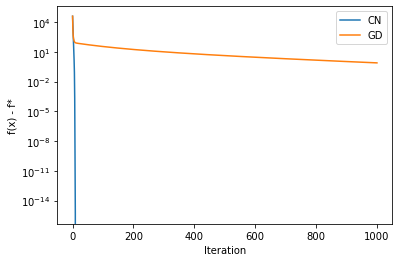

In [20]:
plt.plot(iters_CN, losses_CN-MIN_LOSS, label='CN')
plt.plot(iters_GD, losses_GD-MIN_LOSS, label='GD')
plt.legend()
plt.yscale('log')
plt.ylabel('f(x) - f*')
plt.xlabel('Iteration')
plt.show()

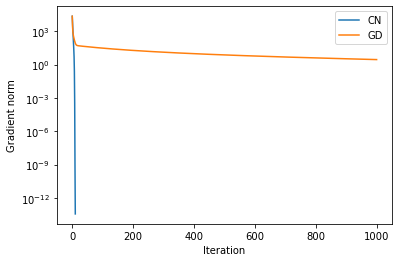

In [21]:
plt.plot(iters_CN, grads_CN, label='CN')
plt.plot(iters_GD, grads_GD, label='GD')
plt.legend()
plt.yscale('log')
plt.ylabel('Gradient norm')
plt.xlabel('Iteration')
plt.show()

# Logistic regression

$\mathcal{L}(w) = \frac{1}{N} \sum_{i=1}^N \log \left( 1 + \exp(-y_i x_i^T w) \right)$

In [7]:
# Creating dataset

X = np.random.uniform(-10, 10, (1000, 5))
w_true = np.array([3.14, 2.71, -1.12, -4.56, 0.51])
score = X @ w_true
noise = np.random.randn(*score.shape) * 25
y = np.sign(score + noise)

c1 = y[y == 1].size
c2 = y[y == -1].size
print(f'{c1} samples of positive class and {c2} samples of negative class')

490 samples of positive class and 510 samples of negative class


In [8]:
def loss(X, y, w):
    return np.mean(- np.log(sigmoid(y * (X@w))))

def gradient(X, y, w):
    N = X.shape[0]
    return (1/N) * X.T @ (-y * sigmoid(-y * (X@w)))

def hessian(X, y, w):
    N = X.shape[0]
    probs = sigmoid(-y*(X@w))
    return (1/N) * X.T @ np.diag(probs*(1-probs)) @ X

def quadratic_form(loss_w, grad_w, hess_w, M, w, w_new):
    diff = w_new - w
    return loss_w + np.dot(grad_w,diff) + 0.5 * np.dot(hess_w @ diff, diff) + M/6 * np.linalg.norm(diff,2)**3

In [9]:
w0 = np.zeros(X.shape[1])
M_0 = 0.01
n_iters = 10

w = train_Cubic_Newton(X, y, w0, n_iters, M_0)

iter   1: loss =  0.43857, M = 0.005
iter   2: loss =  0.40460, M = 0.0025
iter   3: loss =  0.40068, M = 0.00125
iter   4: loss =  0.40060, M = 0.000625
iter   5: loss =  0.40060, M = 0.0003125
iter   6: loss =  0.40060, M = 0.005
iter   7: loss =  0.40060, M = 0.0025
iter   8: loss =  0.40060, M = 0.00125
iter   9: loss =  0.40060, M = 0.000625
iter  10: loss =  0.40060, M = 0.0003125


In [10]:
w0 = np.zeros(X.shape[1])
n_iters = 50
lr = 0.1
w = train_GD(X, y, w0, n_iters, lr)

iter    1: loss =  0.45788
iter    2: loss =  0.42787
iter    3: loss =  0.41595
iter    4: loss =  0.40996
iter    5: loss =  0.40658
iter    6: loss =  0.40454
iter    7: loss =  0.40326
iter    8: loss =  0.40242
iter    9: loss =  0.40186
iter   10: loss =  0.40148
iter   11: loss =  0.40122
iter   12: loss =  0.40104
iter   13: loss =  0.40091
iter   14: loss =  0.40082
iter   15: loss =  0.40076
iter   16: loss =  0.40071
iter   17: loss =  0.40068
iter   18: loss =  0.40066
iter   19: loss =  0.40064
iter   20: loss =  0.40063
iter   21: loss =  0.40062
iter   22: loss =  0.40061
iter   23: loss =  0.40061
iter   24: loss =  0.40061
iter   25: loss =  0.40060
iter   26: loss =  0.40060
iter   27: loss =  0.40060
iter   28: loss =  0.40060
iter   29: loss =  0.40060
iter   30: loss =  0.40060
iter   31: loss =  0.40060
iter   32: loss =  0.40060
iter   33: loss =  0.40060
iter   34: loss =  0.40060
iter   35: loss =  0.40060
iter   36: loss =  0.40060
iter   37: loss =  0.40060
i